# Customer Segmentation Using RFM Analysis in E-commerce

## Introduction

In the realm of e-commerce, understanding customer behavior and preferences is crucial for personalized marketing strategies and enhancing overall customer satisfaction. One effective approach to achieve this is through RFM (Recency, Frequency, Monetary) analysis, a widely used technique that segments customers based on their transaction history.

### Project Overview

This project focuses on analyzing transactional data from an e-commerce platform to segment customers into distinct groups using RFM analysis. The RFM model evaluates customers on three key metrics:

- *Recency*: How recently did a customer make a purchase?
- *Frequency*: How often does a customer make purchases?
- *Monetary*: How much does a customer spend?

### Objectives

The primary objectives of this project include:

- *Customer Segmentation*: Divide customers into clusters based on their RFM scores to identify different segments with varying needs and behaviors.
- *Insights and Recommendations*: Provide actionable insights and targeted recommendations for each customer segment to improve marketing strategies and customer engagement.
- *Visualization*: Visualize clusters using PCA (Principal Component Analysis) to understand the distribution of customers in a reduced-dimensional space.


In [28]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as styles
styles.use('fivethirtyeight')
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore',category=FutureWarning)


In [2]:
# import dataset
df=pd.read_csv(r"C:\Users\Hp\Desktop\data.csv",encoding='unicode_escape')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## Data Inspection and Cleaning

In [3]:
# shape of data
df.shape

(541909, 8)

In [4]:
# null values
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

The missing customer values are so extensive and we cant reliably impute them . we shall drop rows with missing customer values to ensure data integrity.
Similarly we shall drop columns with missing values under description column since it represents a small percentage of our dataset

In [5]:
# drop missing values
df.dropna(inplace=True)

In [6]:
# check column types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.9+ MB


In [7]:
# converting InvoiceDate to datetime 
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])
df['CustomerID']=df['CustomerID'].astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  int32         
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(4)
memory usage: 26.4+ MB


In [8]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [9]:
df.describe(include='object').T

,count,unique,top,freq
InvoiceNo,406829,22190,576339,542
StockCode,406829,3684,85123A,2077
Description,406829,3896,WHITE HANGING HEART T-LIGHT HOLDER,2070
Country,406829,37,United Kingdom,361878


array([[<Axes: title={'center': 'Quantity'}>,
        <Axes: title={'center': 'UnitPrice'}>]], dtype=object)

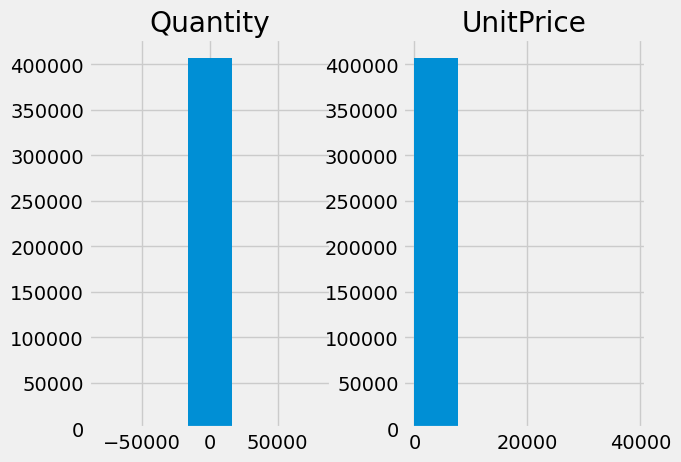

In [10]:
df[['Quantity','UnitPrice']].hist(bins=5)

The histogram for the quantity column shows negative values . This indicates returns made by customers on various dates

In [11]:
# explore non numerical columns
df['Country'].value_counts()

United Kingdom          361878
Germany                   9495
France                    8491
EIRE                      7485
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               1877
Portugal                  1480
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
USA                        291
Israel                     250
Unspecified                244
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon                     45
Lithuani

## Feature Engineering

we shall engineer the following features to help in Segmentation of our dataset 

1. Total Spending: Calculate total spending per invoice (TotalPrice = Quantity * UnitPrice
2. Date Features: Extract features from InvoiceDate like InvoiceYear, InvoiceMonth, InvoiceDay

In [12]:
df['Total Spending']=df['Quantity']*df['UnitPrice']
df['Year']=df['InvoiceDate'].dt.year
df['Month']=df['InvoiceDate'].dt.month
df['Day']=df['InvoiceDate'].dt.day

## Exploratory Data Analysis

we shall conduct  the following analysis on our dataset.
1. **Analyze total sales by CustomerID to identify top customers**
2. **Analyze total sales by month to identify Months with peak sales** 
3. **Analyze Total sales by Country**

<Axes: title={'center': 'Average Sales by Month'}, xlabel='Month'>

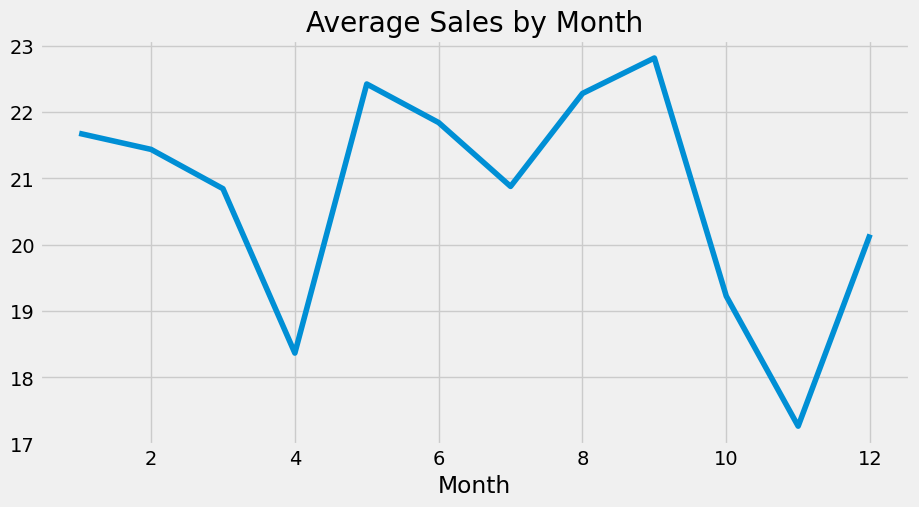

In [13]:
plt.figure(figsize=(10,5))
data=df.groupby(by='Month')['Total Spending'].mean()
plt.title("Average Sales by Month")
data.plot()

1. **On average the months of April  and  November had the lowest sales**
2. **Months of May ,August and September recorder highest average sales**

<Axes: title={'center': 'Top 10 customers with Highest sales'}, xlabel='CustomerID'>

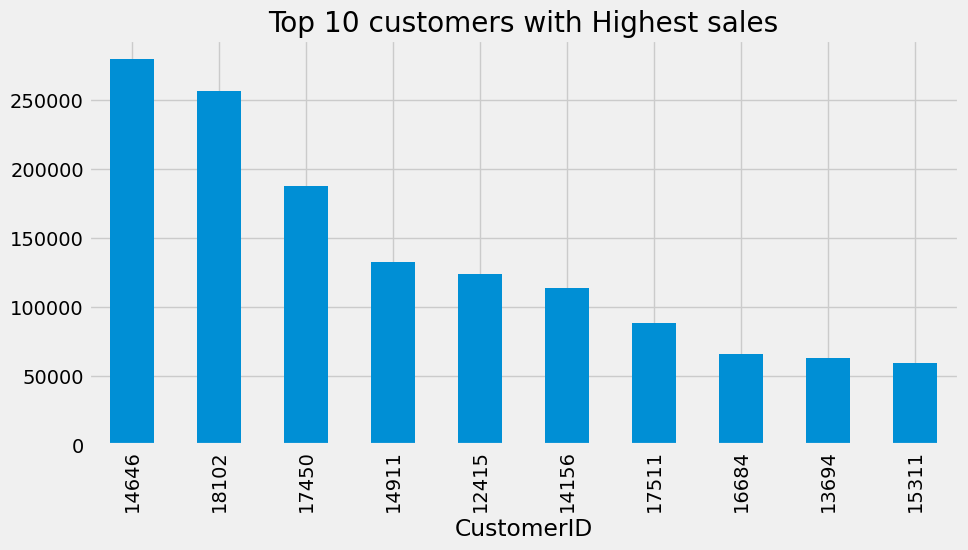

In [14]:
# sales by customer
plt.figure(figsize=(10,5))
data=df.groupby(by='CustomerID')['Total Spending'].sum()
top=data.sort_values(ascending=False).head(10)
plt.title("Top 10 customers with Highest sales")
top.plot.bar()

<Axes: title={'center': 'Top 5 Countries with Highest sales'}, ylabel='Country'>

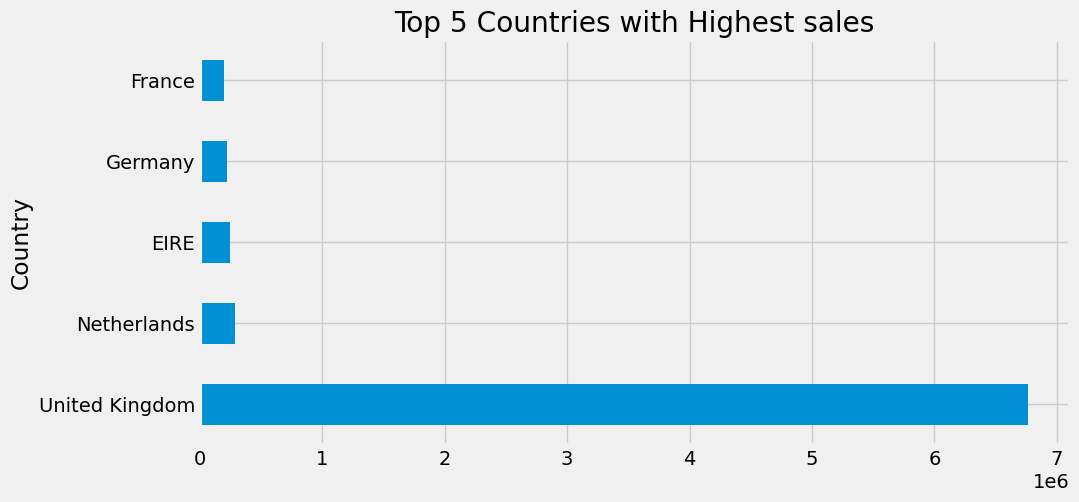

In [31]:
# sales by customer
plt.figure(figsize=(10,5))
data=df.groupby(by='Country')['Total Spending'].sum()
top=data.sort_values(ascending=False).head()
plt.title("Top 5 Countries with Highest sales")
top.plot.barh()

## Segmentation Metrics

1. **Recency** : How recently did the customer make a purchase?
2. **Frequency**: How often does the customer make a purchase?
3. **Monetary**: How much does the customer spend?

In [15]:
# separate purchases df from returns df
purchases_df=df.query("Quantity>=0")

## Recency

In [16]:
most_recent_date=purchases_df["InvoiceDate"].max()
recency_df=purchases_df.groupby('CustomerID')["InvoiceDate"].max().reset_index()
recency_df["Recency"]=(most_recent_date-recency_df["InvoiceDate"]).dt.days
recency_df.head()

,CustomerID,InvoiceDate,Recency
0,12346,2011-01-18 10:01:00,325
1,12347,2011-12-07 15:52:00,1
2,12348,2011-09-25 13:13:00,74
3,12349,2011-11-21 09:51:00,18
4,12350,2011-02-02 16:01:00,309


## Frequency

In [17]:
frequency_df=purchases_df.groupby('CustomerID').size().reset_index(name='Frequency')
frequency_df.head()

,CustomerID,Frequency
0,12346,1
1,12347,182
2,12348,31
3,12349,73
4,12350,17


## Monetary

In [18]:
# have to factor in returns when computing Monetary scores
Monetary_df=df.groupby('CustomerID')['Total Spending'].sum().reset_index()
Monetary_df.columns=['CustomerID','Monetary']
Monetary_df.head()

,CustomerID,Monetary
0,12346,0.00
1,12347,4310.00
2,12348,1797.24
3,12349,1757.55
4,12350,334.40


In [19]:
#RFM DF
RFM_DF=recency_df.merge(frequency_df,on='CustomerID').merge(Monetary_df,on='CustomerID')
RFM_DF.head()

,CustomerID,InvoiceDate,Recency,Frequency,Monetary
0,12346,2011-01-18 10:01:00,325,1,0.00
1,12347,2011-12-07 15:52:00,1,182,4310.00
2,12348,2011-09-25 13:13:00,74,31,1797.24
3,12349,2011-11-21 09:51:00,18,73,1757.55
4,12350,2011-02-02 16:01:00,309,17,334.40


## Scaling the features

In [20]:
scaler=StandardScaler()
scaled_features = scaler.fit_transform(RFM_DF[['Recency', 'Frequency', 'Monetary']])

## Determine Optimal Number of Clusters

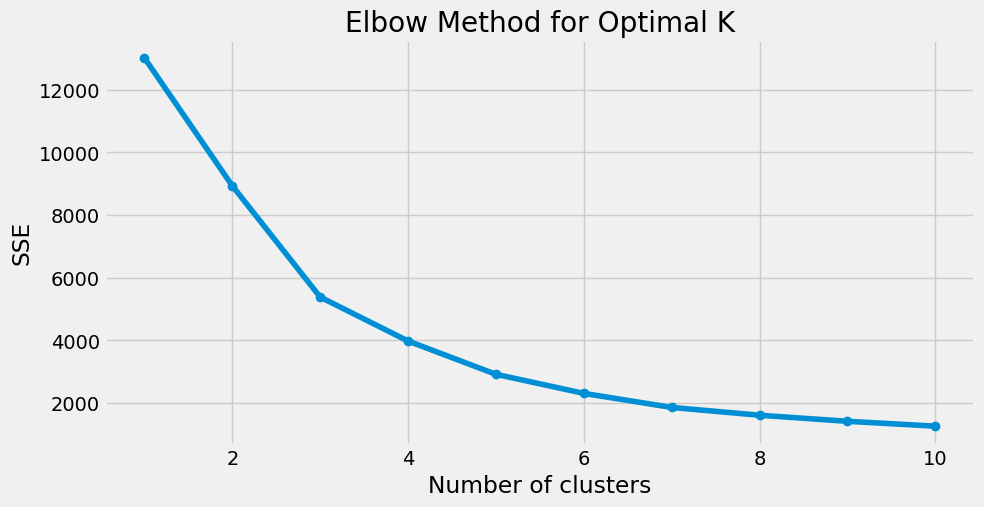

In [21]:
plt.figure(figsize=(10,5))
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method for Optimal K')
plt.show()

## Apply KMeans With Optimal Clusters

In [22]:
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
RFM_DF['Cluster'] = kmeans.fit_predict(scaled_features)

In [23]:
# Cluster profiling
cluster_profile = RFM_DF.groupby('Cluster')[["Recency","Frequency","Monetary"]].mean()
print(cluster_profile)

            Recency    Frequency       Monetary
Cluster                                        
0        246.403151    27.749768     487.603319
1         40.388239   103.025554    1958.065515
2          4.000000  2779.583333  118713.023333


In [24]:
# Evaluate silhoute score
sil_score = silhouette_score(scaled_features, RFM_DF['Cluster'])
print(f'Silhouette Score: {sil_score}')

Silhouette Score: 0.6008896091021737


In [25]:
# cluster centroids
centroids=kmeans.cluster_centers_
print(centroids)

[[ 1.54887582e+00 -2.79581688e-01 -1.73116221e-01]
 [-5.11309923e-01  4.94690711e-02  5.18583593e-03]
 [-8.75198781e-01  1.17494249e+01  1.41624006e+01]]


In [26]:
X=pd.DataFrame(scaled_features,columns=["Recency","Frequency","Monetary"],index=RFM_DF['CustomerID'])
X         

,Recency,Frequency,Monetary
CustomerID,,,
12346,2.334858,-0.396512,-0.232241
12347,-0.905199,0.394688,0.290372
12348,-0.175186,-0.265374,-0.014315
12349,-0.735196,-0.081781,-0.019128
12350,2.174855,-0.326572,-0.191693
...,...,...,...
18280,1.854850,-0.357171,-0.210342
18281,0.884833,-0.370285,-0.222441
18282,-0.845198,-0.348428,-0.210827


## Visualizing Clusters

C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


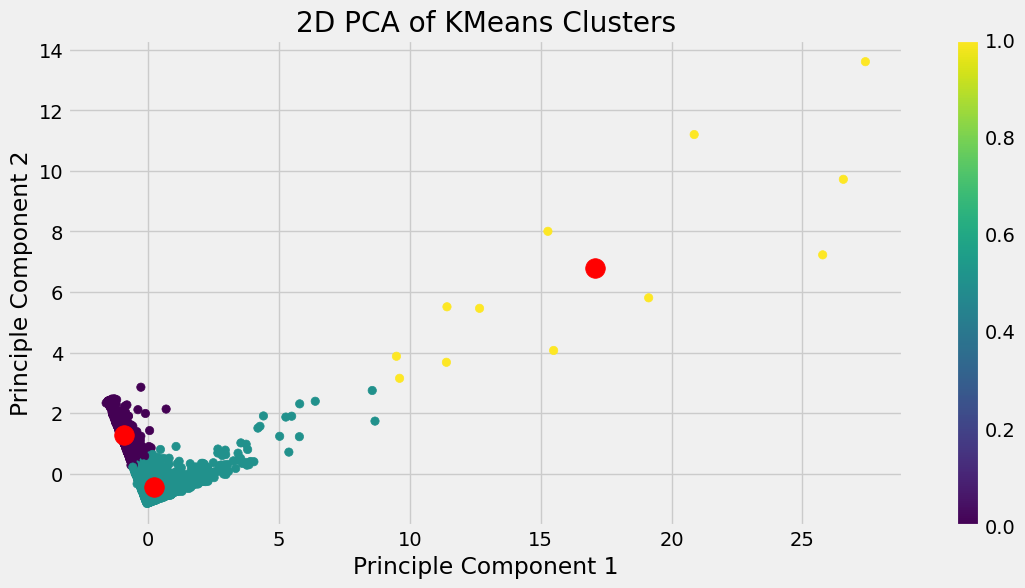

In [32]:
plt.figure(figsize=(12,6))
pca=PCA(n_components=2)
X_pca=pca.fit_transform(X)

plt.scatter(X_pca[:,0],X_pca[:,1],c=kmeans.labels_,cmap='viridis')
plt.scatter(pca.transform(kmeans.cluster_centers_)[:,0],
           pca.transform(kmeans.cluster_centers_)[:,1],
           s=200,c='red',marker='o')
plt.title('2D PCA of KMeans Clusters')
plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')
plt.colorbar()
plt.show()

## Insights and Recommendations

Based on the clusters obtained from customer segmentation using RFM analysis (Recency, Frequency, Monetary Value), here are insights and recommendations for each cluster based on the provided information:

### Cluster 0:
- *Recency*: 246 days average (Least recent)
- *Frequency*: 27 purchases average (Low frequency)
- *Monetary*: $487 average (Low monetary value)

*Insights:*
- These customers have made their last purchase quite a while ago.
- They make relatively few purchases and contribute less monetarily compared to other clusters.

*Recommendations:*
- *Reactivation Campaigns*: Target these customers with personalized offers or incentives to encourage repeat purchases.
- *Engagement Strategies*: Use email marketing or social media to keep these customers informed about new products or promotions.
- *Segment-specific Discounts*: Offer discounts on their previous purchases or related products to stimulate interest.

### Cluster 2:
- *Recency*: 40 days average (Moderately recent)
- *Frequency*: 103 purchases average (Moderate frequency)
- *Monetary*: $1,958 average (Moderate monetary value)

*Insights:*
- These customers have made purchases somewhat recently and exhibit moderate frequency and monetary value.

*Recommendations:*
- *Upsell/Cross-sell*: Recommend complementary products or higher-value items based on their purchase history to increase average order value.
- *Loyalty Rewards*: Implement a loyalty program to reward their frequent purchases and increase retention.
- *Personalized Communication*: Send personalized emails or notifications based on their preferences and purchase behavior.

### Cluster 3:
- *Recency*: 4 days average (Very recent)
- *Frequency*: 2,779 average purchases (High frequency)
- *Monetary*: $118,713 average (High monetary value)

*Insights:*
- These customers have made purchases very recently and are highly active in terms of frequency and monetary contribution.

*Recommendations:*
- *VIP Treatment*: Provide exclusive benefits, such as early access to new products or special events, to strengthen their loyalty.
- *Personalized Offers*: Tailor promotions and discounts based on their purchase history to enhance customer satisfaction and retention.
- *Feedback Loop*: Engage with these customers to gather feedback and insights, showing them their opinions are valued.

